# 1. 데이터 수집하기

In [1]:
# Library load
import time
start_time = time.time()

import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random


In [2]:
# 파라미터 설정
MAX_SAMPLES = 50000     # 초기값 50000, 고정
BUFFER_SIZE = 20000      # 20000, 고정

BATCH_SIZE = 256          # 64

MAX_LENGTH = 40

# 모델 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수 ,2
D_MODEL = 128 # 인코더와 디코더 내부의 입, 출력의 고정 차원,256
NUM_HEADS = 32 # 멀티 헤드 어텐션에서의 헤드 수 ,8
UNITS = 1024 # 피드 포워드 신경망의 은닉층의 크기 , 512
DROPOUT = 0.3 # 드롭아웃의 비율 , 0.1

beta_1=0.9
beta_2=0.98
epsilon=1e-9

EPOCHS = 1000   # 20

In [3]:
path_to_dataset = r'C:\Users\user\Google 드라이브\AIFFEL\Day34\ChatbotData.csv'

cbdata = pd.read_csv(path_to_dataset)
cbdata.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
questions = cbdata.iloc[:,0]
questions_raw = questions
print('질문항 확인')
questions[:10]

질문항 확인


0                     12시 땡!
1                1지망 학교 떨어졌어
2               3박4일 놀러가고 싶다
3            3박4일 정도 놀러가고 싶다
4                    PPL 심하네
5                  SD카드 망가졌어
6                    SD카드 안돼
7             SNS 맞팔 왜 안하지ㅠㅠ
8    SNS 시간낭비인 거 아는데 매일 하는 중
9          SNS 시간낭비인데 자꾸 보게됨
Name: Q, dtype: object

In [5]:
answers = cbdata.iloc[:,1]
answers_raw = answers
print('답변항 확인')
answers[:10]

답변항 확인


0            하루가 또 가네요.
1             위로해 드립니다.
2           여행은 언제나 좋죠.
3           여행은 언제나 좋죠.
4            눈살이 찌푸려지죠.
5    다시 새로 사는 게 마음 편해요.
6    다시 새로 사는 게 마음 편해요.
7      잘 모르고 있을 수도 있어요.
8         시간을 정하고 해보세요.
9         시간을 정하고 해보세요.
Name: A, dtype: object

# 2. 데이터 전처리

In [6]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",", 한글)을 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z?.!,ㄱ-ㅎ|ㅏ-ㅣ]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

random_number = random.randrange(len(questions))
print('시험해볼 행의 번호는: ', random_number+1)
print('전처리 후의 {}번째 질문 샘플: {}'.format(random_number+1, questions[random_number]))
print('전처리 후의 {}번째 답변 샘플: {}'.format(random_number+1, answers[random_number]))

전체 샘플 수 : 11823
전체 샘플 수 : 11823
시험해볼 행의 번호는:  8906
전처리 후의 8906번째 질문 샘플: 각자 집에 인사드리러 가
전처리 후의 8906번째 답변 샘플: 제가 더 떨리네요.


# 3. SubwordTextEncoder 사용하기

In [7]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print('총 어휘 수:', VOCAB_SIZE)

# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 {}번째 질문 샘플: {}'.format(random_number+1, tokenizer.encode(questions[random_number])))
print('정수 인코딩 후의 {}번째 답변 샘플: {}'.format(random_number+1, tokenizer.encode(answers[random_number])))

슝=3
START_TOKEN의 번호 : [8361]
END_TOKEN의 번호 : [8362]
총 어휘 수: 8363
정수 인코딩 후의 8906번째 질문 샘플: [5814, 8137, 341, 941, 2669, 532, 75]
정수 인코딩 후의 8906번째 답변 샘플: [111, 6, 1711, 77, 8151]


In [8]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8363
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


# 4. 모델 구성하기

## (1) 트랜스포머 구현

In [9]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


In [10]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [11]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [12]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [13]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [14]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


## (2) 모델 훈련하기

In [15]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [16]:
tf.keras.backend.clear_session()

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 128)    1730176     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/1000
47/47 [==============================] - 14s 196ms/step - loss: 1.5749 - accuracy: 0.0024
Epoch 2/1000
47/47 [==============================] - 9s 195ms/step - loss: 1.5304 - accuracy: 0.0262
Epoch 3/1000
47/47 [==============================] - 9s 196ms/step - loss: 1.4914 - accuracy: 0.0314
Epoch 4/1000
47/47 [==============================] - 9s 198ms/step - loss: 1.4485 - accuracy: 0.0379
Epoch 5/1000
47/47 [==============================] - 9s 198ms/step - loss: 1.3893 - accuracy: 0.0462
Epoch 6/1000
47/47 [==============================] - 9s 199ms/step - loss: 1.3197 - accuracy: 0.0493
Epoch 7/1000
47/47 [==============================] - 9s 191ms/step - loss: 1.2532 - accuracy: 0.0496
Epoch 8/1000
47/47 [==============================] - 9s 187ms/step - loss: 1.1907 - accuracy: 0.0498
Epoch 9/1000
47/47 [==============================] - 9s 188ms/step - loss: 1.1350 - accuracy: 0.0500
Epoch 10/1000
47/47 [==============================] - 9s 186ms/step - loss: 1.08

47/47 [==============================] - 9s 186ms/step - loss: 0.0558 - accuracy: 0.1595
Epoch 81/1000
47/47 [==============================] - 9s 185ms/step - loss: 0.0539 - accuracy: 0.1602
Epoch 82/1000
47/47 [==============================] - 9s 185ms/step - loss: 0.0533 - accuracy: 0.1600
Epoch 83/1000
47/47 [==============================] - 9s 184ms/step - loss: 0.0517 - accuracy: 0.1606
Epoch 84/1000
47/47 [==============================] - 9s 185ms/step - loss: 0.0506 - accuracy: 0.1607
Epoch 85/1000
47/47 [==============================] - 9s 185ms/step - loss: 0.0482 - accuracy: 0.1614
Epoch 86/1000
47/47 [==============================] - 9s 185ms/step - loss: 0.0483 - accuracy: 0.1614
Epoch 87/1000
47/47 [==============================] - 9s 185ms/step - loss: 0.0465 - accuracy: 0.1618
Epoch 88/1000
47/47 [==============================] - 9s 185ms/step - loss: 0.0457 - accuracy: 0.1620
Epoch 89/1000
47/47 [==============================] - 9s 186ms/step - loss: 0.0422 - a

47/47 [==============================] - 9s 192ms/step - loss: 0.0127 - accuracy: 0.1714
Epoch 160/1000
47/47 [==============================] - 9s 192ms/step - loss: 0.0126 - accuracy: 0.1714
Epoch 161/1000
47/47 [==============================] - 9s 192ms/step - loss: 0.0127 - accuracy: 0.1713
Epoch 162/1000
47/47 [==============================] - 9s 192ms/step - loss: 0.0132 - accuracy: 0.1712
Epoch 163/1000
47/47 [==============================] - 9s 192ms/step - loss: 0.0126 - accuracy: 0.1713
Epoch 164/1000
47/47 [==============================] - 9s 192ms/step - loss: 0.0127 - accuracy: 0.1713
Epoch 165/1000
47/47 [==============================] - 9s 192ms/step - loss: 0.0120 - accuracy: 0.1715
Epoch 166/1000
47/47 [==============================] - 9s 192ms/step - loss: 0.0121 - accuracy: 0.1715
Epoch 167/1000
47/47 [==============================] - 9s 192ms/step - loss: 0.0119 - accuracy: 0.1716
Epoch 168/1000
47/47 [==============================] - 9s 192ms/step - loss: 0

47/47 [==============================] - 9s 192ms/step - loss: 0.0068 - accuracy: 0.1730
Epoch 238/1000
47/47 [==============================] - 9s 192ms/step - loss: 0.0071 - accuracy: 0.1730
Epoch 239/1000
47/47 [==============================] - 9s 192ms/step - loss: 0.0070 - accuracy: 0.1730
Epoch 240/1000
47/47 [==============================] - 9s 192ms/step - loss: 0.0068 - accuracy: 0.1731
Epoch 241/1000
47/47 [==============================] - 9s 193ms/step - loss: 0.0068 - accuracy: 0.1731
Epoch 242/1000
47/47 [==============================] - 9s 197ms/step - loss: 0.0071 - accuracy: 0.1730
Epoch 243/1000
47/47 [==============================] - 9s 199ms/step - loss: 0.0069 - accuracy: 0.1730
Epoch 244/1000
47/47 [==============================] - 9s 198ms/step - loss: 0.0066 - accuracy: 0.1731
Epoch 245/1000
47/47 [==============================] - 9s 199ms/step - loss: 0.0068 - accuracy: 0.1732
Epoch 246/1000
47/47 [==============================] - 9s 198ms/step - loss: 0

47/47 [==============================] - 9s 191ms/step - loss: 0.0046 - accuracy: 0.1737
Epoch 316/1000
47/47 [==============================] - 9s 191ms/step - loss: 0.0047 - accuracy: 0.1737
Epoch 317/1000
47/47 [==============================] - 9s 191ms/step - loss: 0.0046 - accuracy: 0.1737
Epoch 318/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0046 - accuracy: 0.1737
Epoch 319/1000
47/47 [==============================] - 9s 191ms/step - loss: 0.0044 - accuracy: 0.1738
Epoch 320/1000
47/47 [==============================] - 9s 192ms/step - loss: 0.0044 - accuracy: 0.1738
Epoch 321/1000
47/47 [==============================] - 9s 194ms/step - loss: 0.0046 - accuracy: 0.1738
Epoch 322/1000
47/47 [==============================] - 9s 192ms/step - loss: 0.0044 - accuracy: 0.1738
Epoch 323/1000
47/47 [==============================] - 9s 192ms/step - loss: 0.0044 - accuracy: 0.1738
Epoch 324/1000
47/47 [==============================] - 9s 193ms/step - loss: 0

47/47 [==============================] - 9s 194ms/step - loss: 0.0037 - accuracy: 0.1740
Epoch 394/1000
47/47 [==============================] - 9s 195ms/step - loss: 0.0036 - accuracy: 0.1740
Epoch 395/1000
47/47 [==============================] - 9s 195ms/step - loss: 0.0036 - accuracy: 0.1740
Epoch 396/1000
47/47 [==============================] - 9s 195ms/step - loss: 0.0034 - accuracy: 0.1741
Epoch 397/1000
47/47 [==============================] - 9s 195ms/step - loss: 0.0035 - accuracy: 0.1741
Epoch 398/1000
47/47 [==============================] - 9s 202ms/step - loss: 0.0033 - accuracy: 0.1741
Epoch 399/1000
47/47 [==============================] - 9s 194ms/step - loss: 0.0035 - accuracy: 0.1741
Epoch 400/1000
47/47 [==============================] - 9s 195ms/step - loss: 0.0035 - accuracy: 0.1740
Epoch 401/1000
47/47 [==============================] - 9s 191ms/step - loss: 0.0035 - accuracy: 0.1740
Epoch 402/1000
47/47 [==============================] - 9s 192ms/step - loss: 0

47/47 [==============================] - 9s 196ms/step - loss: 0.0029 - accuracy: 0.1742
Epoch 472/1000
47/47 [==============================] - 9s 195ms/step - loss: 0.0029 - accuracy: 0.1742
Epoch 473/1000
47/47 [==============================] - 9s 195ms/step - loss: 0.0029 - accuracy: 0.1742
Epoch 474/1000
47/47 [==============================] - 9s 195ms/step - loss: 0.0030 - accuracy: 0.1742
Epoch 475/1000
47/47 [==============================] - 9s 195ms/step - loss: 0.0027 - accuracy: 0.1743
Epoch 476/1000
47/47 [==============================] - 9s 194ms/step - loss: 0.0028 - accuracy: 0.1743
Epoch 477/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0030 - accuracy: 0.1742
Epoch 478/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0029 - accuracy: 0.1742
Epoch 479/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0030 - accuracy: 0.1742
Epoch 480/1000
47/47 [==============================] - 9s 189ms/step - loss: 0

47/47 [==============================] - 9s 190ms/step - loss: 0.0025 - accuracy: 0.1743
Epoch 550/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0024 - accuracy: 0.1744
Epoch 551/1000
47/47 [==============================] - 9s 191ms/step - loss: 0.0025 - accuracy: 0.1743
Epoch 552/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0025 - accuracy: 0.1743
Epoch 553/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0023 - accuracy: 0.1744
Epoch 554/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0023 - accuracy: 0.1744
Epoch 555/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0023 - accuracy: 0.1744
Epoch 556/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0025 - accuracy: 0.1744
Epoch 557/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0023 - accuracy: 0.1744
Epoch 558/1000
47/47 [==============================] - 9s 190ms/step - loss: 0

47/47 [==============================] - 9s 190ms/step - loss: 0.0022 - accuracy: 0.1744
Epoch 628/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0020 - accuracy: 0.1744
Epoch 629/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0021 - accuracy: 0.1745
Epoch 630/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0021 - accuracy: 0.1745
Epoch 631/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0019 - accuracy: 0.1745
Epoch 632/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0020 - accuracy: 0.1745
Epoch 633/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0020 - accuracy: 0.1745
Epoch 634/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0020 - accuracy: 0.1744
Epoch 635/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0021 - accuracy: 0.1744
Epoch 636/1000
47/47 [==============================] - 9s 189ms/step - loss: 0

47/47 [==============================] - 9s 189ms/step - loss: 0.0020 - accuracy: 0.1745
Epoch 706/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0017 - accuracy: 0.1745
Epoch 707/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0019 - accuracy: 0.1745
Epoch 708/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0017 - accuracy: 0.1745
Epoch 709/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0020 - accuracy: 0.1745
Epoch 710/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0018 - accuracy: 0.1745
Epoch 711/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0017 - accuracy: 0.1745
Epoch 712/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0017 - accuracy: 0.1745
Epoch 713/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0018 - accuracy: 0.1745
Epoch 714/1000
47/47 [==============================] - 9s 189ms/step - loss: 0

47/47 [==============================] - 9s 189ms/step - loss: 0.0017 - accuracy: 0.1745
Epoch 784/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0017 - accuracy: 0.1746
Epoch 785/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0016 - accuracy: 0.1746
Epoch 786/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0016 - accuracy: 0.1746
Epoch 787/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0018 - accuracy: 0.1745
Epoch 788/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0019 - accuracy: 0.1745
Epoch 789/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0015 - accuracy: 0.1746
Epoch 790/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0015 - accuracy: 0.1746
Epoch 791/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0016 - accuracy: 0.1745
Epoch 792/1000
47/47 [==============================] - 9s 189ms/step - loss: 0

47/47 [==============================] - 9s 190ms/step - loss: 0.0016 - accuracy: 0.1745
Epoch 862/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0015 - accuracy: 0.1746
Epoch 863/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0016 - accuracy: 0.1745
Epoch 864/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0014 - accuracy: 0.1746
Epoch 865/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0015 - accuracy: 0.1746
Epoch 866/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0014 - accuracy: 0.1747
Epoch 867/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0016 - accuracy: 0.1746
Epoch 868/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0015 - accuracy: 0.1746
Epoch 869/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0015 - accuracy: 0.1746
Epoch 870/1000
47/47 [==============================] - 9s 189ms/step - loss: 0

47/47 [==============================] - 9s 189ms/step - loss: 0.0014 - accuracy: 0.1746
Epoch 940/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0015 - accuracy: 0.1746
Epoch 941/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0014 - accuracy: 0.1746
Epoch 942/1000
47/47 [==============================] - 9s 190ms/step - loss: 0.0014 - accuracy: 0.1746
Epoch 943/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0016 - accuracy: 0.1746
Epoch 944/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0015 - accuracy: 0.1746
Epoch 945/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0014 - accuracy: 0.1746
Epoch 946/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0013 - accuracy: 0.1747
Epoch 947/1000
47/47 [==============================] - 9s 189ms/step - loss: 0.0014 - accuracy: 0.1746
Epoch 948/1000
47/47 [==============================] - 9s 189ms/step - loss: 0

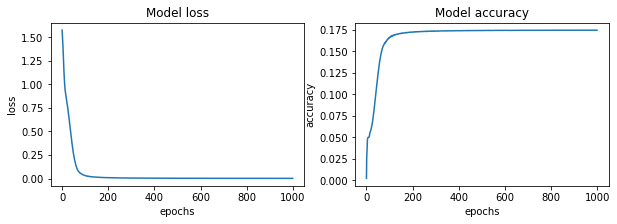

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

for i, met in enumerate(['loss', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    

# 5. 모델 평가

In [19]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence


In [20]:
test_num1 = random.randrange(VOCAB_SIZE)
test_num2 = random.randrange(VOCAB_SIZE)
test_num3 = random.randrange(VOCAB_SIZE)
test_num4 = random.randrange(VOCAB_SIZE)
test_num5 = random.randrange(VOCAB_SIZE)
print('시험해볼 행은 {}, {}, {}, {}, {}입니다.'.format(test_num1, test_num2, test_num3, test_num4, test_num5))

시험해볼 행은 5446, 1179, 954, 7779, 1681입니다.


In [21]:
print('1 번째 문답')
sentence_generation(questions_raw[test_num1])
print('2 번째 문답')
sentence_generation(questions_raw[test_num2])
print('3 번째 문답')
sentence_generation(questions_raw[test_num3])
print('4 번째 문답')
sentence_generation(questions_raw[test_num4])
print('5 번째 문답')
sentence_generation(questions_raw[test_num5])

1 번째 문답
입력 : 감정에 솔직했을 뿐인데 남자들은 싫은 가봐
출력 : 많이 벌수록 좋아요.
2 번째 문답
입력 : 답이 어디있을까?
출력 : 고민하는 것을 보니 무슨 일이 있었나봐요.
3 번째 문답
입력 : 너무 더워
출력 : 많이 벌수록 좋아요.
4 번째 문답
입력 : 인연
출력 : 많이 벌수록 좋아요.
5 번째 문답
입력 : 면접만 남았어
출력 : 많이 벌수록 좋아요.


'많이 벌수록 좋아요.'

In [22]:
end_time = time.time()
print('총 소요시간은 약 {}분입니다.'.format(int((end_time-start_time)//60)))

총 소요시간은 약 150분입니다.


# 회고
- 전처리는 원문이 깔끔하여 추가할 것이 없었다. '영문 외 제외'에서 '영문 및 한글 외 제외'로 약간만 수정하였다. 
- 그래프를 추가하여 수차례의 트레이닝을 통해 loss 및 accuracy가 각각 수렴하는 것을 확인하였다.
- 답변은 5개의 질문을 무작위로 뽑아 이에 대한 답변을 확인하였다. 질문은 5개인데 비해 답변은 2가지, 많아야 3가지인 것이 특징이었다.
- 그리고 이 답변들은 1~2개는 맥락이 영 이상하고 나머지는 그럭저럭 괜찮아 보였다. 하지만 질문 5개에 상응하는 양이 아니어서 최소 3가지 이상의 답변이 나올 수는 없나 하고 파라미터를 조정해 보았다.
- Batch_size, MaxLen, Num_layer, D_model, Num_head, Units, Dropout, beta_1 등을 바꿔가며 시험하였으나 결과에 큰 영향은 없었다. EPOCH 문제인가 싶어 기본 50회이던 것을 마지막에는 1000회까지 늘려도 큰 차이는 나타나지 않았다.
- BERT의 필요성을 증명해주는 코드라고 생각하고 이쯤에서 마무리 한다.

# 마침